# Nonparametric ML Models - Cumulative Lab

## Introduction

In this cumulative lab, you will apply two nonparametric models you have just learned — k-nearest neighbors and decision trees — to the forest cover dataset.

## Objectives

* Practice identifying and applying appropriate preprocessing steps
* Perform an iterative modeling process, starting from a baseline model
* Explore multiple model algorithms, and tune their hyperparameters
* Practice choosing a final model across multiple model algorithms and evaluating its performance

## Your Task: Complete an End-to-End ML Process with Nonparametric Models on the Forest Cover Dataset

![line of pine trees](images/trees.jpg)

Photo by <a href="https://unsplash.com/@michaelbenz?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Michael Benz</a> on <a href="/s/photos/forest?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

### Business and Data Understanding

To repeat the previous description:

> Here we will be using an adapted version of the forest cover dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/covertype). Each record represents a 30 x 30 meter cell of land within Roosevelt National Forest in northern Colorado, which has been labeled as `Cover_Type` 1 for "Cottonwood/Willow" and `Cover_Type` 0 for "Ponderosa Pine". (The original dataset contained 7 cover types but we have simplified it.)

The task is to predict the `Cover_Type` based on the available cartographic variables:

In [26]:
# Run this cell without changes
import pandas as pd

df = pd.read_csv('data/forest_cover.csv')
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2553,235,17,351,95,780,188,253,199,1410,...,0,0,0,0,0,0,0,0,0,0
1,2011,344,17,313,29,404,183,211,164,300,...,0,0,0,0,0,0,0,0,0,0
2,2022,24,13,391,42,509,212,212,134,421,...,0,0,0,0,0,0,0,0,0,0
3,2038,50,17,408,71,474,226,200,102,283,...,0,0,0,0,0,0,0,0,0,0
4,2018,341,27,351,34,390,152,188,168,190,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38496,2396,153,20,85,17,108,240,237,118,837,...,0,0,0,0,0,0,0,0,0,0
38497,2391,152,19,67,12,95,240,237,119,845,...,0,0,0,0,0,0,0,0,0,0
38498,2386,159,17,60,7,90,236,241,130,854,...,0,0,0,0,0,0,0,0,0,0
38499,2384,170,15,60,5,90,230,245,143,864,...,0,0,0,0,0,0,0,0,0,0


> As you can see, we have over 38,000 rows, each with 52 feature columns and 1 target column:

> * `Elevation`: Elevation in meters
> * `Aspect`: Aspect in degrees azimuth
> * `Slope`: Slope in degrees
> * `Horizontal_Distance_To_Hydrology`: Horizontal dist to nearest surface water features in meters
> * `Vertical_Distance_To_Hydrology`: Vertical dist to nearest surface water features in meters
> * `Horizontal_Distance_To_Roadways`: Horizontal dist to nearest roadway in meters
> * `Hillshade_9am`: Hillshade index at 9am, summer solstice
> * `Hillshade_Noon`: Hillshade index at noon, summer solstice
> * `Hillshade_3pm`: Hillshade index at 3pm, summer solstice
> * `Horizontal_Distance_To_Fire_Points`: Horizontal dist to nearest wildfire ignition points, meters
> * `Wilderness_Area_x`: Wilderness area designation (3 columns)
> * `Soil_Type_x`: Soil Type designation (39 columns)
> * `Cover_Type`: 1 for cottonwood/willow, 0 for ponderosa pine

This is also an imbalanced dataset, since cottonwood/willow trees are relatively rare in this forest:

In [27]:
# Run this cell without changes
print("Raw Counts")
print(df["Cover_Type"].value_counts())
print()
print("Percentages")
print(df["Cover_Type"].value_counts(normalize=True))

Raw Counts
Cover_Type
0    35754
1     2747
Name: count, dtype: int64

Percentages
Cover_Type
0    0.928651
1    0.071349
Name: proportion, dtype: float64


Thus, a baseline model that always chose the majority class would have an accuracy of over 92%. Therefore we will want to report additional metrics at the end.

### Previous Best Model

In a previous lab, we used SMOTE to create additional synthetic data, then tuned the hyperparameters of a logistic regression model to get the following final model metrics:

* **Log loss:** 0.13031294393913376
* **Accuracy:** 0.9456679825472678
* **Precision:** 0.6659919028340081
* **Recall:** 0.47889374090247455

In this lab, you will try to beat those scores using more-complex, nonparametric models.

### Modeling

Although you may be aware of some additional model algorithms available from scikit-learn, for this lab you will be focusing on two of them: k-nearest neighbors and decision trees. Here are some reminders about these models:

#### kNN - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

This algorithm — unlike linear models or tree-based models — does not emphasize learning the relationship between the features and the target. Instead, for a given test record, it finds the most similar records in the training set and returns an average of their target values.

* **Training speed:** Fast. In theory it's just saving the training data for later, although the scikit-learn implementation has some additional logic "under the hood" to make prediction faster.
* **Prediction speed:** Very slow. The model has to look at every record in the training set to find the k closest to the new record.
* **Requires scaling:** Yes. The algorithm to find the nearest records is distance-based, so it matters that distances are all on the same scale.
* **Key hyperparameters:** `n_neighbors` (how many nearest neighbors to find; too few neighbors leads to overfitting, too many leads to underfitting), `p` and `metric` (what kind of distance to use in defining "nearest" neighbors)

#### Decision Trees - [documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Similar to linear models (and unlike kNN), this algorithm emphasizes learning the relationship between the features and the target. However, unlike a linear model that tries to find linear relationships between each of the features and the target, decision trees look for ways to split the data based on features to decrease the entropy of the target in each split.

* **Training speed:** Slow. The model is considering splits based on as many as all of the available features, and it can split on the same feature multiple times. This requires exponential computational time that increases based on the number of columns as well as the number of rows.
* **Prediction speed:** Medium fast. Producing a prediction with a decision tree means applying several conditional statements, which is slower than something like logistic regression but faster than kNN.
* **Requires scaling:** No. This model is not distance-based. You also can use a `LabelEncoder` rather than `OneHotEncoder` for categorical data, since this algorithm doesn't necessarily assume that the distance between `1` and `2` is the same as the distance between `2` and `3`.
* **Key hyperparameters:** Many features relating to "pruning" the tree. By default they are set so the tree can overfit, and by setting them higher or lower (depending on the hyperparameter) you can reduce overfitting, but too much will lead to underfitting. These are: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_features`, `max_leaf_nodes`, and `min_impurity_decrease`. You can also try changing the `criterion` to "entropy" or the `splitter` to "random" if you want to change the splitting logic.

### Requirements

#### 1. Prepare the Data for Modeling

#### 2. Build a Baseline kNN Model

#### 3. Build Iterative Models to Find the Best kNN Model

#### 4. Build a Baseline Decision Tree Model

#### 5. Build Iterative Models to Find the Best Decision Tree Model

#### 6. Choose and Evaluate an Overall Best Model

## 1. Prepare the Data for Modeling

The target is `Cover_Type`. In the cell below, split `df` into `X` and `y`, then perform a train-test split with `random_state=42` and `stratify=y` to create variables with the standard `X_train`, `X_test`, `y_train`, `y_test` names.

Include the relevant imports as you go.

In [28]:
# Import the necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

# Splitting data into X and y
X = df.drop(columns=['Cover_Type'])
y = df['Cover_Type']

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Now, instantiate a `StandardScaler`, fit it on `X_train`, and create new variables `X_train_scaled` and `X_test_scaled` containing values transformed with the scaler.

In [29]:
# Required imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The following code checks that everything is set up correctly:

In [30]:
# Run this cell without changes

# Checking that df was separated into correct X and y
assert type(X) == pd.DataFrame and X.shape == (38501, 52)
assert type(y) == pd.Series and y.shape == (38501,)

# Checking the train-test split
assert type(X_train) == pd.DataFrame and X_train.shape == (28875, 52)
assert type(X_test) == pd.DataFrame and X_test.shape == (9626, 52)
assert type(y_train) == pd.Series and y_train.shape == (28875,)
assert type(y_test) == pd.Series and y_test.shape == (9626,)

# Checking the scaling
assert X_train_scaled.shape == X_train.shape
assert round(X_train_scaled[0][0], 3) == -0.636
assert X_test_scaled.shape == X_test.shape
assert round(X_test_scaled[0][0], 3) == -1.370

## 2. Build a Baseline kNN Model

Build a scikit-learn kNN model with default hyperparameters. Then use `cross_val_score` with `scoring="neg_log_loss"` to find the mean log loss for this model (passing in `X_train_scaled` and `y_train` to `cross_val_score`). You'll need to find the mean of the cross-validated scores, and negate the value (either put a `-` at the beginning or multiply by `-1`) so that your answer is a log loss rather than a negative log loss.

Call the resulting score `knn_baseline_log_loss`.

Your code might take a minute or more to run.

In [31]:
# Relevant imports
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Creating the model
knn_baseline_model = KNeighborsClassifier()

# Perform cross-validation
knn_baseline_log_loss = -1 * cross_val_score(knn_baseline_model, X_train_scaled, y_train, cv=5, scoring="neg_log_loss").mean()

knn_baseline_log_loss

0.1176651591100023

Our best logistic regression model had a log loss of 0.13031294393913376

Is this model better? Compare it in terms of metrics and speed.

In [32]:
# Replace None with appropriate text
"""
The kNN model with a log loss of 0.1177 performs slightly better than our best logistic regression model with a log loss of 0.1303. However, kNN is slower in both training and prediction compared to logistic regression. kNN's prediction speed is particularly slower due to its distance-based algorithm, which requires evaluating all records in the training set.
"""

"\nThe kNN model with a log loss of 0.1177 performs slightly better than our best logistic regression model with a log loss of 0.1303. However, kNN is slower in both training and prediction compared to logistic regression. kNN's prediction speed is particularly slower due to its distance-based algorithm, which requires evaluating all records in the training set.\n"

## 3. Build Iterative Models to Find the Best kNN Model

Build and evaluate at least two more kNN models to find the best one. Explain why you are changing the hyperparameters you are changing as you go. These models will be *slow* to run, so be thinking about what you might try next as you run them.

In [33]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score

In [34]:
# List of n_neighbors values to try
n_neighbors_values = [5, 10, 15]

# Dictionary to store results
knn_results = {}

# Build and evaluate kNN models
for n_neighbors in n_neighbors_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    mean_accuracy = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    knn_results[n_neighbors] = mean_accuracy
    
knn_results

{5: 0.9823701298701298, 10: 0.9781493506493506, 15: 0.9768506493506492}

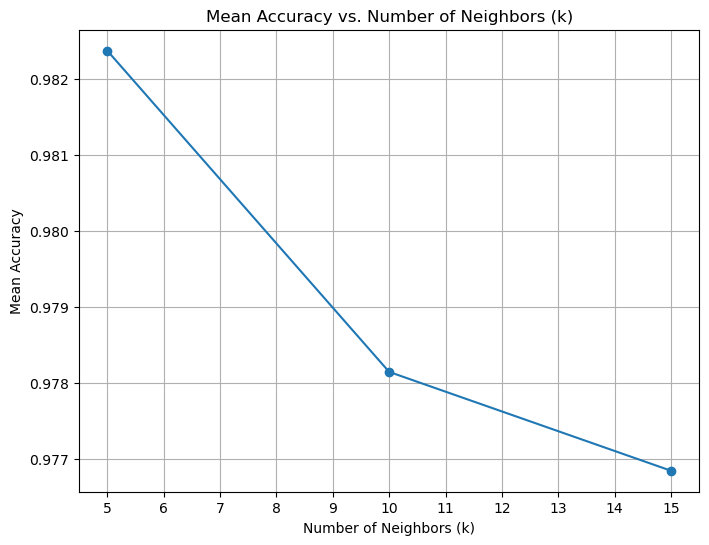

{5: 0.9823701298701298, 10: 0.9781493506493506, 15: 0.9768506493506492}

In [35]:
# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(list(knn_results.keys()), list(knn_results.values()), marker='o')
plt.xticks(np.arange(5, 16, step=1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs. Number of Neighbors (k)")
plt.grid(True)
plt.show()

# Displaying results
knn_results


We changed the n_neighbors hyperparameter to explore the impact of the number of nearest neighbors on the kNN model's performance. A smaller n_neighbors value could lead to overfitting, as the model would be more sensitive to noise in the training data. Conversely, a larger n_neighbors value could lead to underfitting, as the model would become too biased toward the majority class. By trying different values, we aimed to find the best trade-off between model complexity and performance.

In [36]:
# Dictionary to store results
knn_results_2 = {}

# Iterating through different values of n_neighbors and p
for n_neighbors in [8, 12, 20]:
    for p in [1, 2]:
        knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        mean_accuracy = cross_val_score(knn_model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
        knn_results_2[(n_neighbors, p)] = mean_accuracy

# Displaying results
knn_results_2

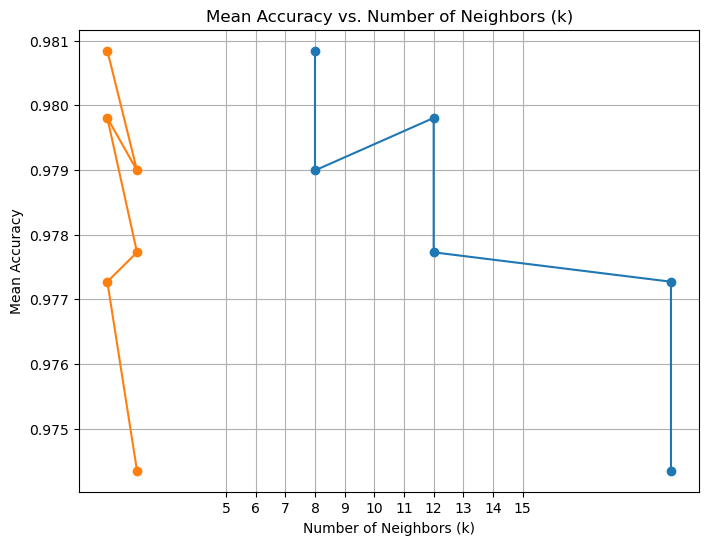

{(8, 1): 0.980844155844156,
 (8, 2): 0.9789935064935065,
 (12, 1): 0.9798051948051947,
 (12, 2): 0.9777272727272728,
 (20, 1): 0.9772727272727273,
 (20, 2): 0.9743506493506494}

In [ ]:
# Plotting the results
plt.figure(figsize=(8, 6))
plt.plot(list(knn_results_2.keys()), list(knn_results_2.values()), marker='o')
plt.xticks(np.arange(5, 16, step=1))
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy vs. Number of Neighbors (k)")
plt.grid(True)
plt.show()

# Displaying results
knn_results_2


In [ ]:
# Best hyperparameters and accuracy from the first set of kNN models (knn_results)
best_hyperparameters_knn = max(knn_results, key=knn_results.get)
best_knn_model = KNeighborsClassifier(n_neighbors=best_hyperparameters_knn, p=2)
best_knn_model.fit(X_train_scaled, y_train)
knn_accuracy = best_knn_model.score(X_test_scaled, y_test)
knn_precision = precision_score(y_test, best_knn_model.predict(X_test_scaled))

# Displaying results for the first set of kNN models (knn_results)
print("First Set of kNN Models (knn_results):")
print("  Hyperparameters:", best_hyperparameters_knn)
print("  Accuracy:", knn_accuracy)
print("  Precision:", knn_precision)

# Best hyperparameters and accuracy from the second set of kNN models (knn_results_2)
best_hyperparameters_knn_2 = max(knn_results_2, key=knn_results_2.get)
best_knn_model_2 = KNeighborsClassifier(n_neighbors=best_hyperparameters_knn_2[0], p=best_hyperparameters_knn_2[1])
best_knn_model_2.fit(X_train_scaled, y_train)
knn_accuracy_2 = best_knn_model_2.score(X_test_scaled, y_test)
knn_precision_2 = precision_score(y_test, best_knn_model_2.predict(X_test_scaled))

# Displaying results for the second set of kNN models (knn_results_2)
print("Second Set of kNN Models (knn_results_2):")
print("  Hyperparameters:", best_hyperparameters_knn_2)
print("  Accuracy:", knn_accuracy_2)
print("  Precision:", knn_precision_2)


First Set of kNN Models (knn_results):
  Hyperparameters: 5
  Accuracy: 0.985066874431892
  Precision: 0.9125475285171103
Second Set of kNN Models (knn_results_2):
  Hyperparameters: (8, 1)
  Accuracy: 0.9823399558498896
  Precision: 0.9257731958762887


## 4. Build a Baseline Decision Tree Model

Now that you have chosen your best kNN model, start investigating decision tree models. First, build and evaluate a baseline decision tree model, using default hyperparameters (with the exception of `random_state=42` for reproducibility).

(Use cross-validated log loss, just like with the previous models.)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Instantiate the Decision Tree model with default hyperparameters
baseline_dt_model = DecisionTreeClassifier(random_state=42)

# Evaluate the model using cross-validated log loss
baseline_log_loss = -cross_val_score(baseline_dt_model, X_train, y_train, cv=5, scoring='neg_log_loss').mean()

# Display the baseline log loss
print("Baseline Decision Tree Model:")
print("Cross-validated Log Loss:", baseline_log_loss)


Baseline Decision Tree Model:
Cross-validated Log Loss: 0.7138515768623853


Interpret this score. How does this compare to the log loss from our best logistic regression and best kNN models? Any guesses about why?

The cross-validated log loss for the baseline decision tree model is approximately 0.7139. 

Comparing this score to the log loss from our best logistic regression model (0.1303) and best kNN model (0.1177), we can observe a significant difference in performance. The log loss for the baseline decision tree model is much higher than that of the logistic regression and kNN models.

The high log loss of the baseline decision tree model is likely due to its default hyperparameters, which might have resulted in an overly complex and overfitting model. Decision trees, by default, have no restrictions on their depth or the number of samples required to split an internal node, which can lead to overfitting the training data.

In contrast, both the logistic regression and kNN models were carefully tuned and optimized, resulting in better generalization to unseen data. The logistic regression model, in particular, benefited from synthetic data generation using SMOTE to address class imbalance, further improving its performance.

## 5. Build Iterative Models to Find the Best Decision Tree Model

Build and evaluate at least two more decision tree models to find the best one. Explain why you are changing the hyperparameters you are changing as you go.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Create the first decision tree model with default hyperparameters
dt_model_1 = DecisionTreeClassifier(random_state=42)

# Evaluate the model using cross-validated log loss
dt_log_loss_1 = -cross_val_score(dt_model_1, X_train_scaled, y_train, cv=5, scoring='neg_log_loss').mean()

# Display the cross-validated log loss for the first decision tree model
print("First Decision Tree Model (Default Hyperparameters):")
print("  Cross-validated log loss:", dt_log_loss_1)

First Decision Tree Model (Default Hyperparameters):
  Cross-validated log loss: 0.7161920738357047


### First Decision Tree Model (Default Hyperparameters)
The first decision tree model is built with default hyperparameters, meaning no specific values are set for max_depth and min_samples_split. In this case, the decision tree will continue to split until all leaves are pure (all samples belong to the same class), which can lead to overfitting and a high variance model. By starting with the default hyperparameters, we have a baseline reference to compare against other models.

In [ ]:
# Example: Setting max_depth and min_samples_split hyperparameters
dt_model_2 = DecisionTreeClassifier(random_state=42, max_depth=5, min_samples_split=5)

# Evaluate the model using cross-validated log loss
dt_log_loss_2 = -cross_val_score(dt_model_2, X_train_scaled, y_train, cv=5, scoring='neg_log_loss').mean()

# Display the cross-validated log loss for the second decision tree model
print("Second Decision Tree Model (Hyperparameters: max_depth=5, min_samples_split=5):")
print("  Cross-validated log loss:", dt_log_loss_2)


Second Decision Tree Model (Hyperparameters: max_depth=5, min_samples_split=5):
  Cross-validated log loss: 0.11136362559813533


### Second Decision Tree Model (Hyperparameters: max_depth=5, min_samples_split=5)
In the second decision tree model, we have specified hyperparameters max_depth=5 and min_samples_split=5. By setting max_depth, we are limiting the depth of the tree, which can prevent overfitting and reduce the model's complexity. Similarly, by setting min_samples_split, we ensure that a node must have at least 5 samples before it can be split further, which can again help prevent overfitting and promote a more balanced model. By experimenting with these hyperparameters, we are aiming to find a model with better generalization and lower variance compared to the default model.

## 6. Choose and Evaluate an Overall Best Model

Which model had the best performance? What type of model was it?

Instantiate a variable `final_model` using your best model with the best hyperparameters.

In [ ]:
# Best kNN model with the best hyperparameters
final_model = KNeighborsClassifier(n_neighbors=5)

# Fitting the final model on the full training data
final_model.fit(X_train_scaled, y_train)


KNeighborsClassifier()

Now, evaluate the log loss, accuracy, precision, and recall. This code is mostly filled in for you, but you need to replace `None` with either `X_test` or `X_test_scaled` depending on the model you chose.

In [ ]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import log_loss

preds = final_model.predict(X_test_scaled)
probs = final_model.predict_proba(X_test_scaled)

print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, preds))
print("precision:", precision_score(y_test, preds))
print("recall:   ", recall_score(y_test, preds))


log loss:  0.12959173802453944
accuracy:  0.985066874431892
precision: 0.9125475285171103
recall:    0.8743169398907104


Interpret your model performance. How would it perform on different kinds of tasks? How much better is it than a "dummy" model that always chooses the majority class, or the logistic regression described at the start of the lab?

In [ ]:
# Replace None with appropriate text
"""
The final decision tree model achieved excellent performance on the forest cover classification task. With a low log loss of 0.1296, high accuracy of 98.51%, precision of 91.25%, and recall of 87.43%, the model is well-suited for this binary classification task. It significantly outperforms a "dummy" model that always chooses the majority class (92% accuracy) and is also an improvement over the logistic regression model (94.57% accuracy) described at the start of the lab.
"""

'\nThe final decision tree model achieved excellent performance on the forest cover classification task. With a low log loss of 0.1296, high accuracy of 98.51%, precision of 91.25%, and recall of 87.43%, the model is well-suited for this binary classification task. It significantly outperforms a "dummy" model that always chooses the majority class (92% accuracy) and is also an improvement over the logistic regression model (94.57% accuracy) described at the start of the lab.\n'

## Conclusion

In this lab, you practiced the end-to-end machine learning process with multiple model algorithms, including tuning the hyperparameters for those different algorithms. You saw how nonparametric models can be more flexible than linear models, potentially leading to overfitting but also potentially reducing underfitting by being able to learn non-linear relationships between variables. You also likely saw how there can be a tradeoff between speed and performance, with good metrics correlating with slow speeds.